# Dasasets downloading and pkgs importing

In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 18.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=a69c275965e3618ea4f7df28e91a9abe14f31f19e4f8da9bd73c4928bd652f27
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
import os
os.environ['KAGGLE_USERNAME']='nagulapatisaiprakash'
os.environ['KAGGLE_KEY']="aeab6c065b082bf253f1ebca92f18efc"

In [ ]:
!kaggle datasets download -d currie32/crimes-in-chicago

 99% 463M/467M [00:03<00:00, 151MB/s]
100% 467M/467M [00:03<00:00, 137MB/s]


In [ ]:
!unzip -q crimes-in-chicago.zip

In [ ]:
## spark imports
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

In [ ]:
## standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Preprocessing and Visualization

## Columns description in dataset

In [ ]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''


In [ ]:
def entry_dic(line):
    """
    Convert a header - description line into a single dictionary that holds the original header as 'title', a corresponding field name as 'header', and a description.
    """
    pair = line.split(' - ')
    return {'title': pair[0], 'description': pair[1], 'header': pair[0].lower().replace(' ', '_')}

In [ ]:
filtered = []
for line in content_cols.split('\n'):
    if line != '':
        filtered.append(line)

header_dics = list(map(entry_dic, filtered))

In [ ]:
header_dics[:2]

[{'description': 'Unique identifier for the record.',
  'header': 'id',
  'title': 'ID'},
 {'description': 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.',
  'header': 'case_number',
  'title': 'Case Number'}]

## Loading datasets

In [ ]:
spark = SparkSession.builder.master("local[1]").appName("ChicagoCrimesSpark").getOrCreate()

In [ ]:
df = spark.read.csv('*.csv', inferSchema=True, header=True)

In [ ]:
df = df.cache()

In [ ]:
df.printSchema()

root
 |-- _c0: long (nullable = true)
 |-- id: long (nullable = true)
 |-- case_number: string (nullable = true)
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- beat: string (nullable = true)
 |-- district: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: string (nullable = true)
 |-- y_coordinate: string (nullable = true)
 |-- year: string (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- month: date (nullable = tru

In [ ]:
for h in header_dics:
    df = df.withColumnRenamed(h['title'], h['header'])

In [ ]:
df.show(n=3, truncate=False)

+----+-------+-----------+----------------------+-------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|_c0 |id     |case_number|date                  |block              |iucr|primary_type              |description                  |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on            |latitude    |longitude    |location                     |
+----+-------+-----------+----------------------+-------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|879 |4786321|HM399414   |01/01

# Processing data to explore various features

In [ ]:
df = df.rdd.filter(lambda rec: rec.arrest.find('Location Description') < 0).toDF().cache()

In [ ]:
df.show(n=3, truncate=False)

+----+-------+-----------+----------------------+-------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|_c0 |id     |case_number|date                  |block              |iucr|primary_type              |description                  |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on            |latitude    |longitude    |location                     |
+----+-------+-----------+----------------------+-------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|879 |4786321|HM399414   |01/01

## Crime types Record

In [ ]:
# crime types
crime_type_groups = df.groupBy('primary_type').count()

In [ ]:
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)

In [ ]:
print(df.count())

7941285


In [ ]:
df.columns

['_c0',
 'id',
 'case_number',
 'date',
 'block',
 'iucr',
 'primary_type',
 'description',
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'x_coordinate',
 'y_coordinate',
 'year',
 'updated_on',
 'latitude',
 'longitude',
 'location']

In [ ]:
df.printSchema()

root
 |-- _c0: long (nullable = true)
 |-- id: long (nullable = true)
 |-- case_number: string (nullable = true)
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- beat: string (nullable = true)
 |-- district: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: string (nullable = true)
 |-- y_coordinate: string (nullable = true)
 |-- year: string (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- location: string (nullable = true)



In [ ]:
crime_type_counts.show(truncate=False)

+--------------------------------+-------+
|primary_type                    |count  |
+--------------------------------+-------+
|THEFT                           |1640506|
|BATTERY                         |1442717|
|CRIMINAL DAMAGE                 |923000 |
|NARCOTICS                       |885431 |
|OTHER OFFENSE                   |491923 |
|ASSAULT                         |481661 |
|BURGLARY                        |470958 |
|MOTOR VEHICLE THEFT             |370548 |
|ROBBERY                         |300453 |
|DECEPTIVE PRACTICE              |280931 |
|CRIMINAL TRESPASS               |229367 |
|PROSTITUTION                    |86401  |
|WEAPONS VIOLATION               |77429  |
|PUBLIC PEACE VIOLATION          |58548  |
|OFFENSE INVOLVING CHILDREN      |51441  |
|CRIM SEXUAL ASSAULT             |29868  |
|SEX OFFENSE                     |28707  |
|GAMBLING                        |18806  |
|LIQUOR LAW VIOLATION            |17513  |
|INTERFERENCE WITH PUBLIC OFFICER|15710  |
+----------

In [ ]:
counts_pddf = pd.DataFrame(crime_type_counts.rdd.map(lambda l: l.asDict()).collect())

In [ ]:
counts_pddf.head(10)

,primary_type,count
0,THEFT,1640506
1,BATTERY,1442717
2,CRIMINAL DAMAGE,923000
3,NARCOTICS,885431
4,OTHER OFFENSE,491923
5,ASSAULT,481661
6,BURGLARY,470958
7,MOTOR VEHICLE THEFT,370548
8,ROBBERY,300453
9,DECEPTIVE PRACTICE,280931


[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crimes Record Count')]

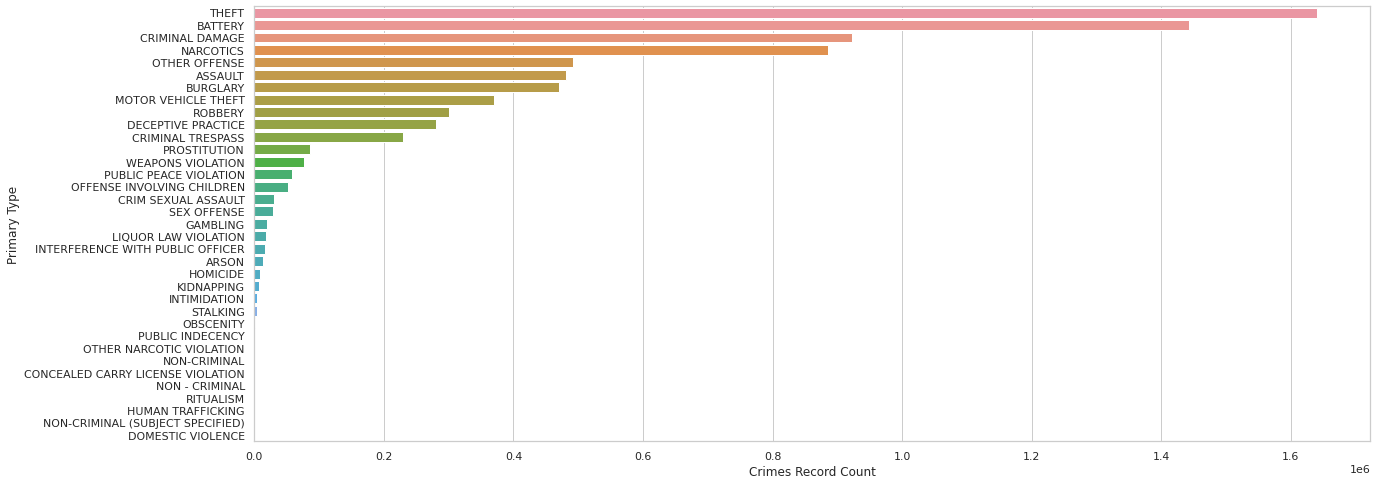

In [ ]:
plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='primary_type', data=counts_pddf)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

## Year-on-year Crimes

In [ ]:
df.select(min('date').alias('first_record_date'), max('date').alias('latest_record_date')).show(truncate=False)

+----------------------+----------------------+
|first_record_date     |latest_record_date    |
+----------------------+----------------------+
|01/01/2001 01:00:00 AM|12/31/2016 12:56:00 AM|
+----------------------+----------------------+



In [ ]:
#adding a month column to be able to view stats on a monthly basis
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', trunc('date_time', 'YYYY')) 

In [ ]:
df.select(['date','date_time', 'month'])\
  .show(n=2, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|01/01/2004 12:01:00 AM|2004-01-01 00:01:00|2004-01-01|
|03/01/2003 12:00:00 AM|2003-03-01 00:00:00|2003-01-01|
+----------------------+-------------------+----------+
only showing top 2 rows



In [ ]:
# crime types and arrest over years:
type_arrest_date = df.groupBy(['arrest', 'month'])\
                     .count()\
                     .orderBy(['month', 'count'], ascending=[True, False])
print()
type_arrest_date.show(3, truncate=False)


+------+----------+------+
|arrest|month     |count |
+------+----------+------+
|False |2001-01-01|400628|
|True  |2001-01-01|167890|
|False |2002-01-01|348074|
+------+----------+------+
only showing top 3 rows



In [ ]:
# A pandas data frame of the collected dictionary version of the date-grouped DF above
type_arrest_pddf = pd.DataFrame(type_arrest_date.rdd.map(lambda l: l.asDict()).collect())

In [ ]:
type_arrest_pddf['yearpd'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%Y'))

In [ ]:
type_arrest_pddf['arrest'] = type_arrest_pddf['arrest'].apply(lambda l: l=='True')
type_arrest_pddf.head(5)

,arrest,month,count,yearpd
0,False,2001-01-01,400628,2001
1,True,2001-01-01,167890,2001
2,False,2002-01-01,348074,2002
3,True,2002-01-01,142805,2002
4,False,2003-01-01,334414,2003


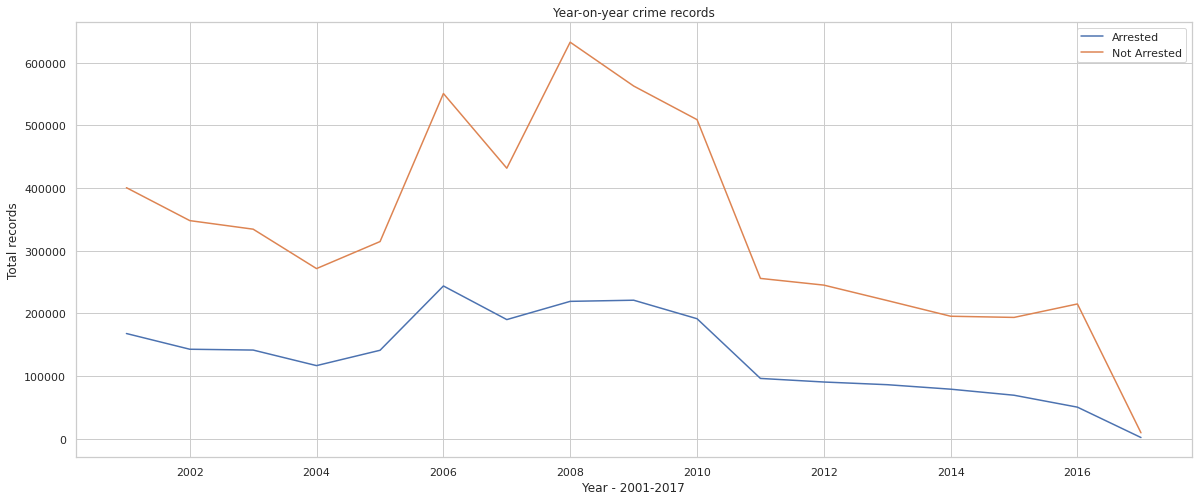

In [ ]:
# Data for plotting
t = type_arrest_pddf['count'] - 20 # np.arange(0.0, 2.0, 0.01)
s = type_arrest_pddf['month']

arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == True]
not_arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == False]

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(arrested['month'], arrested['count'], label='Arrested')
ax.plot(not_arrested['month'], not_arrested['count'], label='Not Arrested')

ax.set(xlabel='Year - 2001-2017', ylabel='Total records',
       title='Year-on-year crime records')
ax.grid(b=True, which='both', axis='y')
ax.legend()

## Hourly crimes

In [ ]:
# Extract the "hour" field from the date into a separate column called "hour"
df_hour = df.withColumn('hour', hour(df['date_time']))

In [ ]:
# Derive a data frame with crime counts per hour of the day:
hourly_count = df_hour.groupBy(['primary_type', 'hour']).count().cache()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

In [ ]:
hourly_count_pddf = pd.DataFrame(hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'].alias('count'))\
                                .rdd.map(lambda l: l.asDict())\
                                 .collect())

In [ ]:
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')

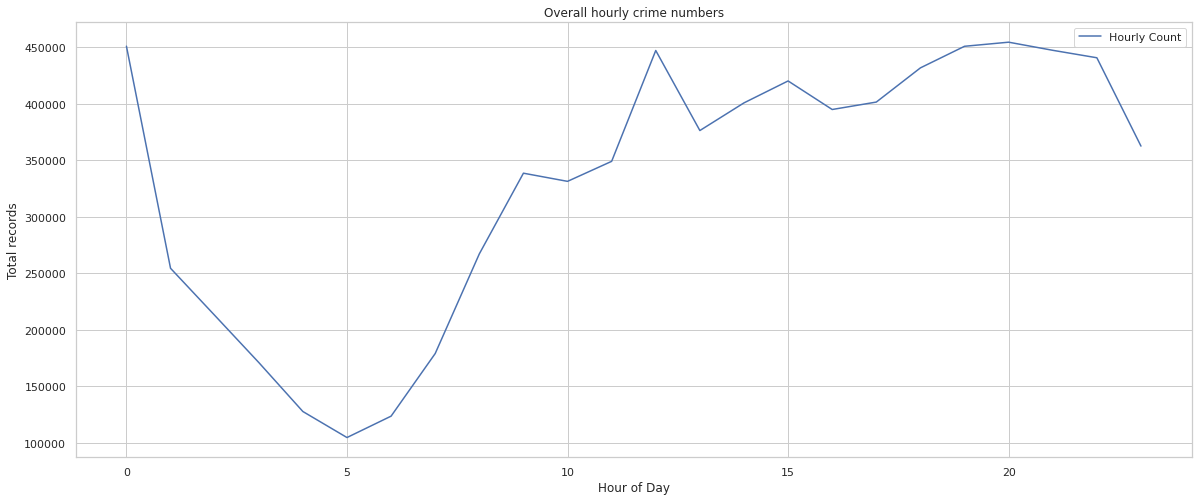

In [ ]:
fig, ax = plt.subplots()
ax.plot(hourly_count_pddf['hour'], hourly_count_pddf['count'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
ax.grid(b=True, which='both', axis='y')
ax.legend()

In [ ]:
# Number of types of location recorded in the dataset
df.select('location_description').distinct().count()

173

In [ ]:
df.groupBy(['location_description']).count().orderBy('count', ascending=False).show(10)

+--------------------+-------+
|location_description|  count|
+--------------------+-------+
|              STREET|2101843|
|           RESIDENCE|1341750|
|            SIDEWALK| 815595|
|           APARTMENT| 812512|
|               OTHER| 294286|
|PARKING LOT/GARAG...| 225454|
|               ALLEY| 180155|
|SCHOOL, PUBLIC, B...| 173750|
|    RESIDENCE-GARAGE| 158550|
|RESIDENCE PORCH/H...| 138492|
+--------------------+-------+
only showing top 10 rows



## Domestic Crimes

In [ ]:
domestic_hour = pd.DataFrame(df_hour.groupBy(['domestic', 'hour']).count().orderBy('hour').rdd.map(lambda row: row.asDict()).collect())

In [ ]:
dom = domestic_hour[domestic_hour['domestic'] == 'True']['count']
non_dom = domestic_hour[domestic_hour['domestic'] == 'False']['count']

either_dom = domestic_hour.groupby(by=['hour']).sum()['count']

dom_keys = domestic_hour[domestic_hour['domestic'] == 'False']['hour']

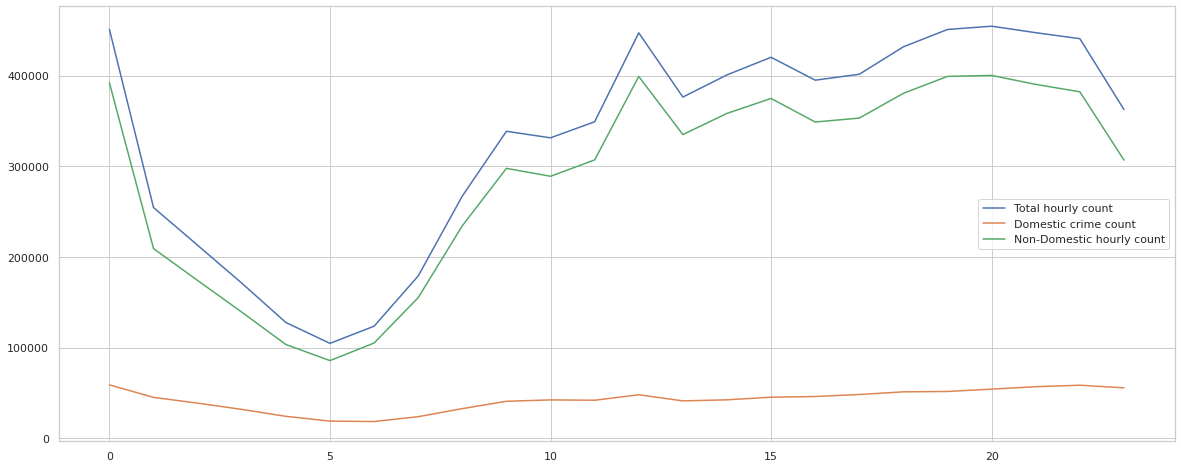

In [ ]:
figure, axes = plt.subplots()

axes.plot(dom_keys, either_dom, label='Total hourly count')
axes.plot(dom_keys, dom, label='Domestic crime count')
axes.plot(dom_keys, non_dom, label='Non-Domestic hourly count')

axes.legend()

## Day in Week Crimes

In [ ]:

df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [ ]:
df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|01/01/2004 12:01:00 AM|2004-01-01|0   |5       |2004|1         |1        |1095       |
|03/01/2003 12:00:00 AM|2003-01-01|0   |7       |2003|3         |1        |789        |
|06/20/2004 11:00:00 AM|2004-01-01|11  |1       |2004|6         |20       |1266       |
|12/30/2004 08:00:00 PM|2004-01-01|20  |5       |2004|12        |30       |1459       |
|05/01/2003 01:00:00 AM|2003-01-01|1   |5       |2003|5         |1        |850        |
|08/01/2004 12:01:00 AM|2004-01-01|0   |1       |2004|8         |1        |1308       |
|01/01/2001 11:00:00 AM|2001-01-01|11  |2       |2001|1         |1        |0          |
|03/15/2003 12:00:00 AM|2003-01-01|0   |7       |2003|3         |15       |803        |
|09/16/2004 10:00:00 AM|2004-01-

In [ ]:
week_day_crime_counts = df_dates.groupBy('week_day').count()

In [ ]:
week_day_crime_counts_pddf = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())

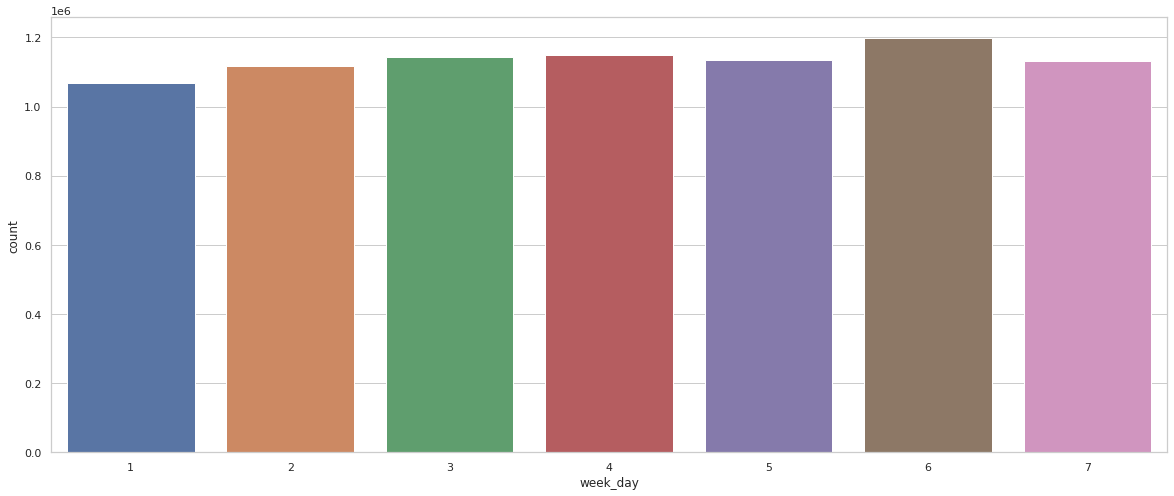

In [ ]:
sns.barplot(data=week_day_crime_counts_pddf, x='week_day', y='count')

## Month in Year Crimes

In [ ]:
year_month_crime_counts = df_dates.groupBy('year_month').count()

In [ ]:
year_month_crime_counts_pddf = pd.DataFrame(year_month_crime_counts.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())

In [ ]:
year_month_crime_counts_pddf

,year_month,count
0,1,660357
1,2,564178
2,3,639692
3,4,649755
4,5,730039
5,6,711768
6,7,730949
7,8,724522
8,9,679295
9,10,687450


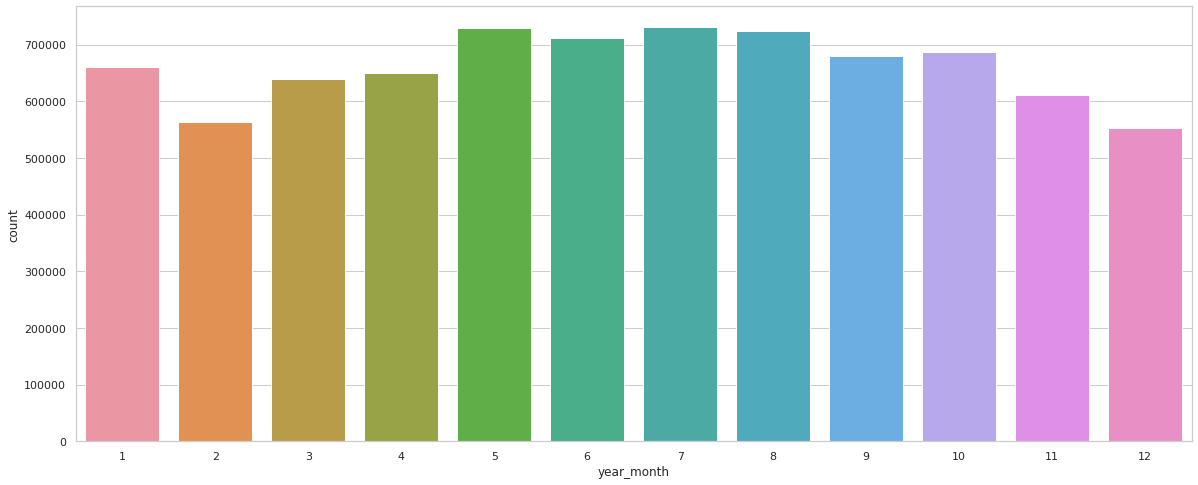

In [ ]:
sns.barplot(data=year_month_crime_counts_pddf, y='count', x='year_month')

## Day in Month Crimes

In [ ]:
month_day_crime_counts = df_dates.groupBy('month_day').count()

In [ ]:
month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())

In [ ]:
month_day_crime_counts_pddf.sort_values(by='count', ascending=False).head(10)

,month_day,count
0,1,309994
14,15,271113
19,20,264762
9,10,263976
13,14,263507
11,12,263193
16,17,261727
8,9,261387
15,16,261078
7,8,260775


In [ ]:
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)

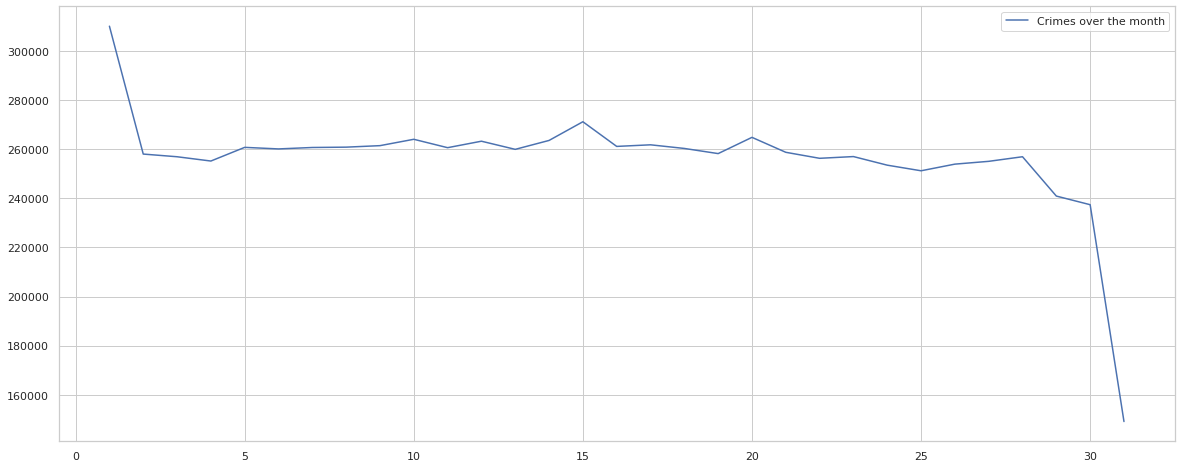

In [ ]:
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

## Alalysing Top most crimes w.r.t Hour and Community Area

In [ ]:
df_dates_community_areas = df_dates.na.drop(subset=['community_area']).groupBy('community_area').count()

In [ ]:
df_dates_community_areas.orderBy('count', ascending=False).show(10)

+--------------+------+
|community_area| count|
+--------------+------+
|          25.0|467137|
|          43.0|237381|
|           8.0|235562|
|          23.0|229024|
|          67.0|216991|
|          24.0|213915|
|          71.0|207183|
|          28.0|206017|
|          29.0|202887|
|          68.0|197659|
+--------------+------+
only showing top 10 rows



In [ ]:
top_crime_types = df_dates.select('primary_type').groupBy('primary_type').count().rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])
top_busy_areas =  df_dates_community_areas.rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])

In [ ]:
top_crime_types_lst = [dc['primary_type'] for dc in top_crime_types]
top_busy_areas_lst = [dc['community_area'] for dc in top_busy_areas]

In [ ]:
top_crime_types_lst

['THEFT',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'OTHER OFFENSE',
 'ASSAULT',
 'BURGLARY',
 'MOTOR VEHICLE THEFT',
 'ROBBERY',
 'DECEPTIVE PRACTICE']

In [ ]:
top_busy_areas_lst

['25.0', '43.0', '8.0', '23.0', '67.0', '24.0', '71.0', '28.0', '29.0', '68.0']

In [ ]:
q1 = "instr('" + ' '.join(top_busy_areas_lst) + "', community_area) > 0"
q2 = "instr('" + ' '.join(top_crime_types_lst) + "', primary_type) > 0"
print(q1)
print(q2)

instr('25.0 43.0 8.0 23.0 67.0 24.0 71.0 28.0 29.0 68.0', community_area) > 0
instr('THEFT BATTERY CRIMINAL DAMAGE NARCOTICS OTHER OFFENSE ASSAULT BURGLARY MOTOR VEHICLE THEFT ROBBERY DECEPTIVE PRACTICE', primary_type) > 0


In [ ]:
## Construct a data frame filtered on these top community areas and top crime types:
df_dates_tops = df_dates.filter(q1).filter(q2)

In [ ]:
df_dates_tops.count()

2608136

In [ ]:
tops_of_tops = df_dates_tops.groupBy(['primary_type', 'community_area']).count().orderBy(['primary_type', 'count', 'community_area'], ascending=[True, False, True]).cache()

In [ ]:
tops_of_tops.show(20)

+------------+--------------+-----+
|primary_type|community_area|count|
+------------+--------------+-----+
|     ASSAULT|          25.0|27112|
|     ASSAULT|          43.0|16358|
|     ASSAULT|          67.0|15576|
|     ASSAULT|          68.0|15064|
|     ASSAULT|          71.0|14342|
|     ASSAULT|          23.0|14081|
|     ASSAULT|          29.0|12605|
|     ASSAULT|          28.0|11096|
|     ASSAULT|          24.0|10119|
|     ASSAULT|           8.0| 8385|
|     ASSAULT|           1.0| 6459|
|     ASSAULT|           3.0| 6335|
|     ASSAULT|           7.0| 2871|
|     ASSAULT|           4.0| 2427|
|     ASSAULT|           5.0| 1726|
|     ASSAULT|           9.0|  362|
|     BATTERY|          25.0|91430|
|     BATTERY|          43.0|51026|
|     BATTERY|          67.0|50855|
|     BATTERY|          68.0|49025|
+------------+--------------+-----+
only showing top 20 rows



## Crimes w.r.t Community Area

In [ ]:
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [ ]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]

In [ ]:
code_pairs[:5]

[[1.0, 'Rogers Park'],
 [40.0, 'Washington Park'],
 [2.0, 'West Ridge'],
 [41.0, 'Hyde Park'],
 [3.0, 'Uptown']]

In [ ]:
community_area_counts = pd.DataFrame(df_dates_community_areas.rdd.map(lambda row: row.asDict()).collect())

In [ ]:
# Create a dictionary of area code to names
area_name_dic = {float(k[0]):k[1] for k in code_pairs}

In [ ]:
community_area_counts['community_area_name'] = community_area_counts['community_area'].apply(lambda area: area_name_dic.get(float(area),  'unknown_%s'%area))

In [ ]:
community_area_counts = community_area_counts.sort_values(by='count')
community_area_counts.head(5)

,community_area,count,community_area_name
22,0.0,114,unknown_0.0
24,9.0,6983,Edison Park
11,47.0,10957,Burnside
25,12.0,12969,Forest Glen
53,55.0,15554,Hegewisch


In [ ]:
code_pairs_df = spark.createDataFrame(code_pairs, ['community_area', 'area_name'])

In [ ]:
named_tops_of_tops = code_pairs_df.join(tops_of_tops, on='community_area', how='right')

In [ ]:
named_tops_of_tops.show(10)

+--------------+---------------+-------------------+-----+
|community_area|      area_name|       primary_type|count|
+--------------+---------------+-------------------+-----+
|           8.0|Near North Side|            ASSAULT| 8385|
|           8.0|Near North Side|            BATTERY|31008|
|           8.0|Near North Side|           BURGLARY| 5635|
|           8.0|Near North Side|    CRIMINAL DAMAGE|15840|
|           8.0|Near North Side| DECEPTIVE PRACTICE|20796|
|           8.0|Near North Side|MOTOR VEHICLE THEFT| 4961|
|           8.0|Near North Side|          NARCOTICS|12647|
|           8.0|Near North Side|      OTHER OFFENSE| 8621|
|           8.0|Near North Side|            ROBBERY| 5763|
|           8.0|Near North Side|              THEFT|96280|
+--------------+---------------+-------------------+-----+
only showing top 10 rows



In [ ]:
tops_of_tops_dff = pd.DataFrame(named_tops_of_tops.rdd.map(lambda l: l.asDict()).collect() )

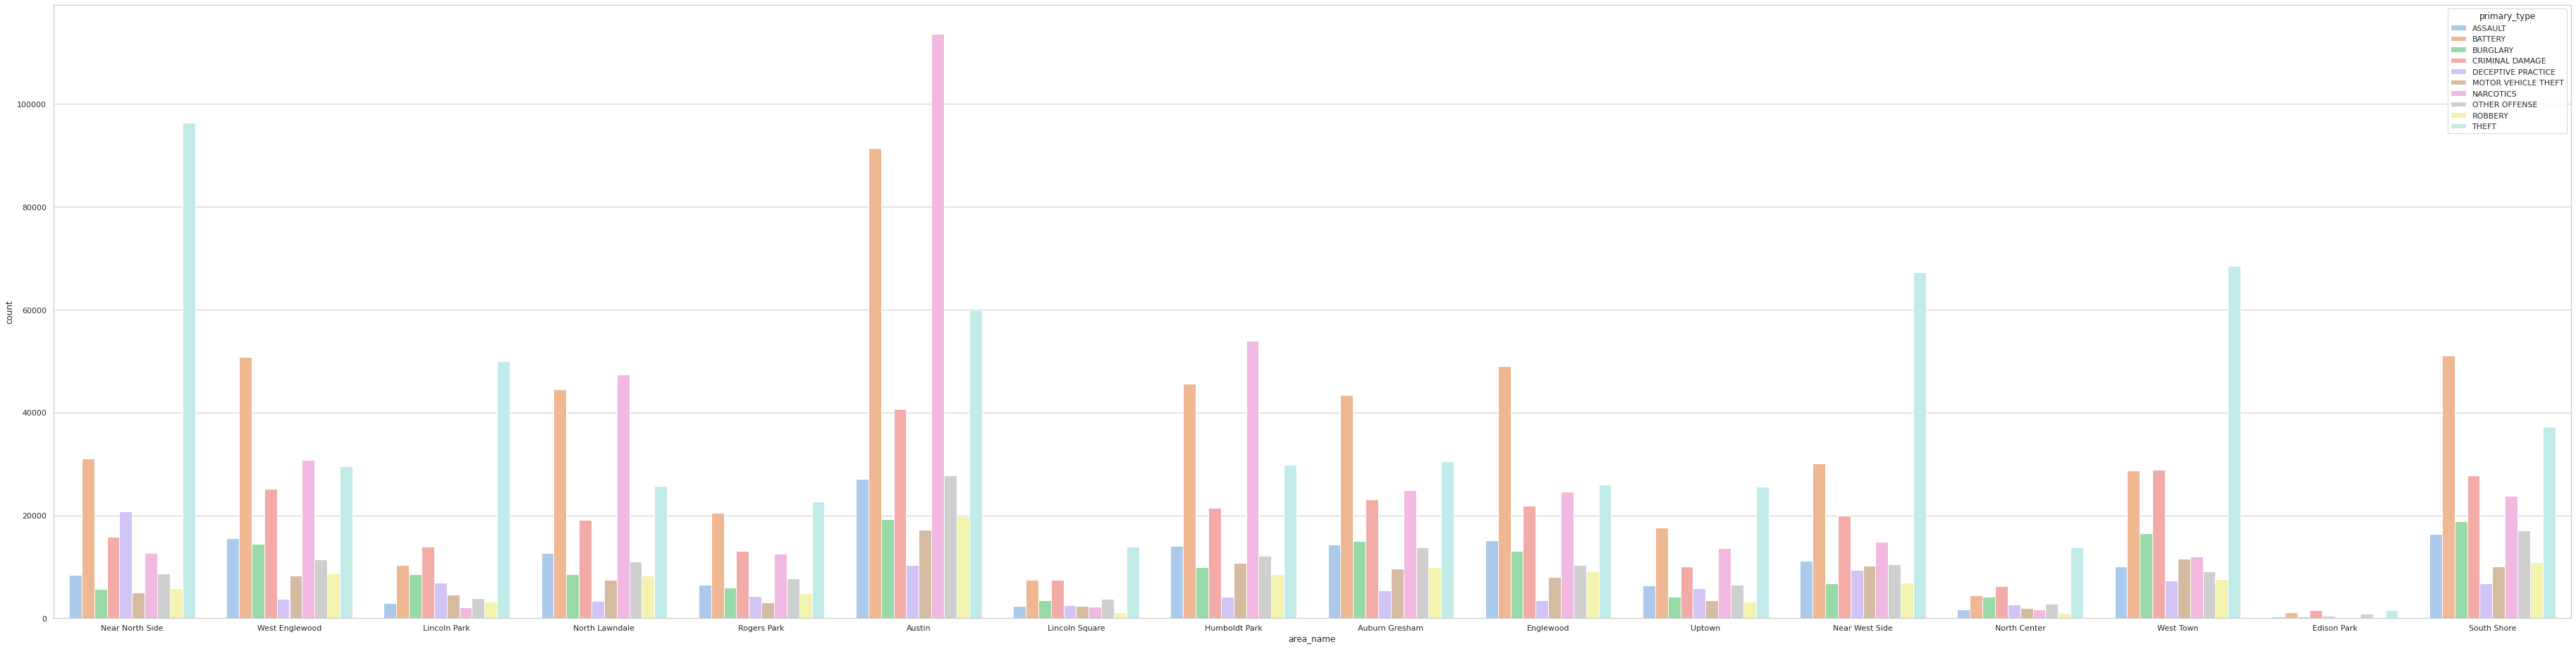

In [ ]:
plt.rcParams["figure.figsize"] = [64, 16]
sns.barplot(data=tops_of_tops_dff, x='area_name', y='count', hue='primary_type', palette='pastel')

# Modeling data

## Indexing columns - StringIndexer

In [ ]:
selected_features = [
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'hour',
 'week_day',
 'year_month',
 'month_day',
 'date_number']

In [ ]:
#Let's see the schema of these selected features:
features_df = df_dates.select(selected_features)
features_df.printSchema()

root
 |-- location_description: string (nullable = true)
 |-- arrest: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- beat: string (nullable = true)
 |-- district: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- week_day: integer (nullable = true)
 |-- year_month: integer (nullable = true)
 |-- month_day: integer (nullable = true)
 |-- date_number: integer (nullable = true)



In [ ]:
feature_level_count_dic = []

for feature in selected_features:
    print('Counting %s' % feature)
    levels_list_df = features_df.select(feature).distinct()
    feature_level_count_dic.append({'feature': feature, 'level_count': levels_list_df.count()})

Counting location_description
Counting arrest
Counting domestic
Counting beat
Counting district
Counting ward
Counting community_area
Counting fbi_code
Counting hour
Counting week_day
Counting year_month
Counting month_day
Counting date_number


In [ ]:
pd.DataFrame(feature_level_count_dic).sort_values(by='level_count', ascending=False)

,feature,level_count
12,date_number,5862
3,beat,304
0,location_description,173
6,community_area,79
5,ward,51
11,month_day,31
4,district,27
7,fbi_code,26
8,hour,24
10,year_month,12


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
df_dates_features = df_dates.na.drop(subset=selected_features)

In [ ]:
df_dates_features.show(3)

+----+-------+-----------+--------------------+-------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-------------------+----------+----+--------+----------+---------+-----------+----------------------------+--------------+----------------+------------+----------------+------------+----------------------+----------------+------------+----------------+------------------+-----------------+-------------------+--------------------+
| _c0|     id|case_number|                date|              block|iucr|        primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|          updated_on|    latitude|    longitude|            location|          date_time|     month|hour|week_day|year_month|month_day|date_number|loc

In [ ]:
for feature in feature_level_count_dic:
    indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature'])
    print('Fitting feature "%s"' % feature['feature'])
    model = indexer.fit(df_dates_features)
    print('Transforming "%s"' % feature['feature'])
    df_dates_features = model.transform(df_dates_features)

Fitting feature "location_description"
Transforming "location_description"
Fitting feature "arrest"
Transforming "arrest"
Fitting feature "domestic"
Transforming "domestic"
Fitting feature "beat"
Transforming "beat"
Fitting feature "district"
Transforming "district"
Fitting feature "ward"
Transforming "ward"
Fitting feature "community_area"
Transforming "community_area"
Fitting feature "fbi_code"
Transforming "fbi_code"
Fitting feature "hour"
Transforming "hour"
Fitting feature "week_day"
Transforming "week_day"
Fitting feature "year_month"
Transforming "year_month"
Fitting feature "month_day"
Transforming "month_day"
Fitting feature "date_number"
Transforming "date_number"


In [ ]:
## String-indexing:
response_indexer = StringIndexer(inputCol='primary_type', outputCol='primary_type_indexed')
response_model = response_indexer.fit(df_dates_features)
df_dates_features = response_model.transform(df_dates_features)

In [ ]:

df_dates_features.show(5)

+----+-------+-----------+--------------------+-------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-------------------+----------+----+--------+----------+---------+-----------+----------------------------+--------------+----------------+------------+----------------+------------+----------------------+----------------+------------+----------------+------------------+-----------------+-------------------+--------------------+
| _c0|     id|case_number|                date|              block|iucr|        primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|          updated_on|    latitude|    longitude|            location|          date_time|     month|hour|week_day|year_month|month_day|date_number|loc

In [ ]:
indexed_features = ['%s_indexed' % fc['feature'] for fc in feature_level_count_dic]
indexed_features

['location_description_indexed',
 'arrest_indexed',
 'domestic_indexed',
 'beat_indexed',
 'district_indexed',
 'ward_indexed',
 'community_area_indexed',
 'fbi_code_indexed',
 'hour_indexed',
 'week_day_indexed',
 'year_month_indexed',
 'month_day_indexed',
 'date_number_indexed']

In [ ]:
assembler = VectorAssembler(inputCols=indexed_features, outputCol='features')
vectorized_df_dates = assembler.transform(df_dates_features)

In [ ]:
vectorized_df_dates.select('features').take(1)

[Row(features=DenseVector([1.0, 0.0, 0.0, 45.0, 5.0, 15.0, 19.0, 0.0, 0.0, 3.0, 9.0, 0.0, 1134.0]))]

In [ ]:
train, test = vectorized_df_dates.randomSplit([0.6, 0.4])

In [ ]:
from pyspark.ml.classification import LogisticRegression

## Predicting Type of Crime using 13 features

### Modelling

In [ ]:
logisticRegression = LogisticRegression(labelCol='primary_type_indexed', featuresCol='features', maxIter=10, family='multinomial')

In [ ]:
fittedModel = logisticRegression.fit(train)

### Results

In [ ]:
model_summary = fittedModel.summary

In [ ]:
fittedModel.coefficientMatrix

DenseMatrix(34, 13, [0.0308, -1.8903, -2.4426, 0.003, 0.0558, 0.0051, 0.0003, -1.283, ..., 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0], 1)

In [ ]:
print(fittedModel.coefficientMatrix)

DenseMatrix([[ 3.07513266e-02, -1.89034037e+00, -2.44256205e+00,
               3.04881556e-03,  5.57587435e-02,  5.14809195e-03,
               3.33503642e-04, -1.28297755e+00,  4.57833419e-02,
               1.41857569e-01,  6.26019433e-02,  3.30767126e-02,
               1.93808922e-04],
             [ 1.74849744e-02, -2.98669655e-01,  2.80682968e+00,
               2.17995687e-03,  2.83977350e-02,  1.75757331e-03,
               3.24582543e-03, -4.09697031e-01,  3.18460542e-02,
               1.12260613e-01,  1.24461915e-02,  1.97049501e-02,
               2.08491665e-05],
             [ 9.59517046e-04, -2.68206362e+00,  3.24930899e-01,
               9.70126383e-04,  6.37730364e-03,  1.79417828e-02,
               5.74978085e-03, -4.28126206e-01,  4.30014976e-02,
               1.50000291e-01,  4.39254993e-02,  2.80902906e-02,
               7.58193234e-05],
             [-5.87472483e-02,  7.34627070e+00, -2.53928765e+00,
              -3.51922893e-03, -4.66086620e-02, -3.36669621

In [ ]:
print('Coefficient matrix:\nRow count = %s\nCol count = %s' % (fittedModel.coefficientMatrix.numRows, fittedModel.coefficientMatrix.numCols))

Coefficient matrix:
Row count = 34
Col count = 13


In [ ]:
print('Model:\nNum Classes = %s\nNum Features = %s' % (fittedModel.numClasses, fittedModel.numFeatures))

Model:
Num Classes = 34
Num Features = 13


In [ ]:
print('Training "primary_type" factor level count = %s' % train.select('primary_type_indexed').distinct().count())

Training "primary_type" factor level count = 34


In [ ]:
vectorized_df_dates.select('features').show(2, truncate=False)

+------------------------------------------------------------+
|features                                                    |
+------------------------------------------------------------+
|[1.0,0.0,0.0,45.0,5.0,15.0,19.0,0.0,0.0,3.0,9.0,0.0,1134.0] |
|[1.0,0.0,1.0,128.0,7.0,29.0,15.0,4.0,0.0,4.0,8.0,0.0,1590.0]|
+------------------------------------------------------------+
only showing top 2 rows



In [ ]:
 train.select('primary_type_indexed').distinct().count()

34

In [ ]:
fittedModel.interceptVector.values.size

34

In [ ]:
print(model_summary.objectiveHistory)
print()
print('Objective history size ', len(model_summary.objectiveHistory))

[2.407577564177401, 2.103235140638118, 1.992866899343106, 1.8563120896130045, 1.7857545338203962, 1.739461627806069, 1.6952568826518142, 1.644722322554021, 1.5970710714805967, 1.5755748998247139, 1.5584711054788614]

Objective history size  11


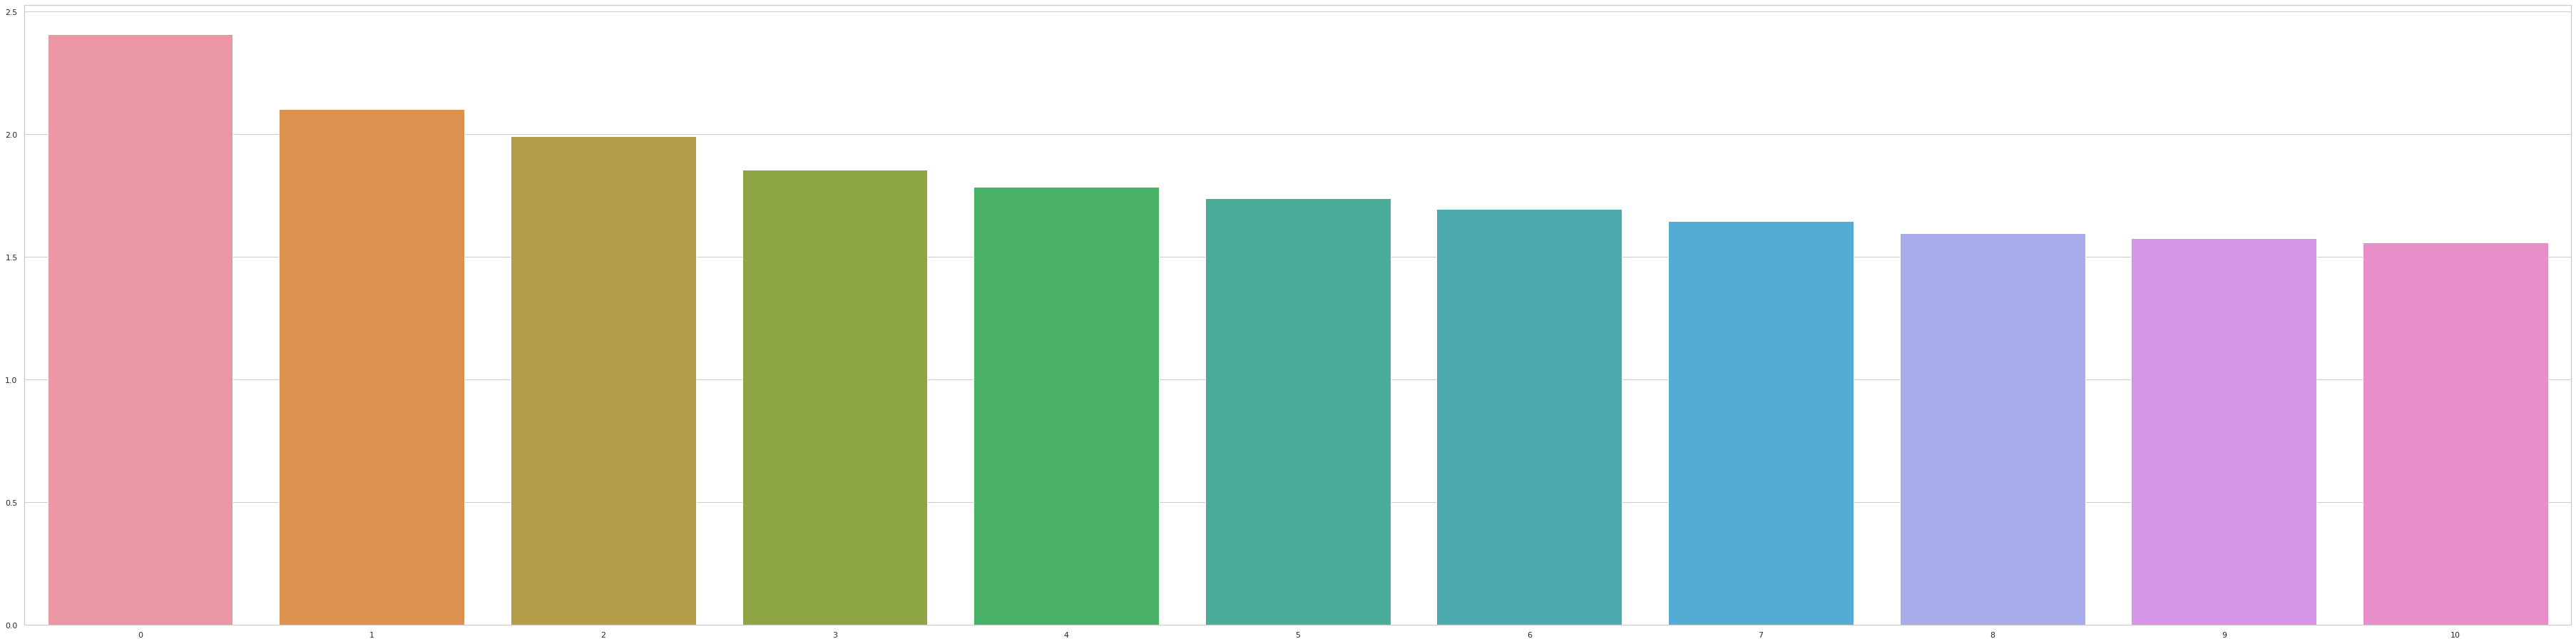

In [ ]:
sns.barplot(y=model_summary.objectiveHistory, x=list(range(len(model_summary.objectiveHistory))))

### Rates of prediction

In [ ]:
label_stats = {float(i):{'index': float(i)} for i in range(34)}
print(label_stats)

{0.0: {'index': 0.0}, 1.0: {'index': 1.0}, 2.0: {'index': 2.0}, 3.0: {'index': 3.0}, 4.0: {'index': 4.0}, 5.0: {'index': 5.0}, 6.0: {'index': 6.0}, 7.0: {'index': 7.0}, 8.0: {'index': 8.0}, 9.0: {'index': 9.0}, 10.0: {'index': 10.0}, 11.0: {'index': 11.0}, 12.0: {'index': 12.0}, 13.0: {'index': 13.0}, 14.0: {'index': 14.0}, 15.0: {'index': 15.0}, 16.0: {'index': 16.0}, 17.0: {'index': 17.0}, 18.0: {'index': 18.0}, 19.0: {'index': 19.0}, 20.0: {'index': 20.0}, 21.0: {'index': 21.0}, 22.0: {'index': 22.0}, 23.0: {'index': 23.0}, 24.0: {'index': 24.0}, 25.0: {'index': 25.0}, 26.0: {'index': 26.0}, 27.0: {'index': 27.0}, 28.0: {'index': 28.0}, 29.0: {'index': 29.0}, 30.0: {'index': 30.0}, 31.0: {'index': 31.0}, 32.0: {'index': 32.0}, 33.0: {'index': 33.0}}


In [ ]:
print("False positive rate by label:")
for i, rate in enumerate(model_summary.falsePositiveRateByLabel):
    label_stats[i]['false_positive_rate'] = rate
    
for i, rate in enumerate(model_summary.truePositiveRateByLabel):
    label_stats[i]['true_positive_rate'] = rate
    
for i, rate in enumerate(model_summary.precisionByLabel):
    label_stats[i]['precision_rate'] = rate
    
for i, rate in enumerate(model_summary.recallByLabel):
    label_stats[i]['recall_rate'] = rate
    
for i, rate in enumerate(model_summary.fMeasureByLabel()):
    label_stats[i]['f_measure'] = rate


False positive rate by label:


In [ ]:
train_rdd = train.select(['primary_type', 'primary_type_indexed']).distinct().orderBy('primary_type_indexed').rdd.map(lambda l: l.asDict()).collect()

In [ ]:
for l in train_rdd:
    print(l)
    label_stats[l['primary_type_indexed']]['primary_type'] = l['primary_type']

{'primary_type': 'THEFT', 'primary_type_indexed': 0.0}
{'primary_type': 'BATTERY', 'primary_type_indexed': 1.0}
{'primary_type': 'CRIMINAL DAMAGE', 'primary_type_indexed': 2.0}
{'primary_type': 'NARCOTICS', 'primary_type_indexed': 3.0}
{'primary_type': 'OTHER OFFENSE', 'primary_type_indexed': 4.0}
{'primary_type': 'ASSAULT', 'primary_type_indexed': 5.0}
{'primary_type': 'BURGLARY', 'primary_type_indexed': 6.0}
{'primary_type': 'MOTOR VEHICLE THEFT', 'primary_type_indexed': 7.0}
{'primary_type': 'ROBBERY', 'primary_type_indexed': 8.0}
{'primary_type': 'DECEPTIVE PRACTICE', 'primary_type_indexed': 9.0}
{'primary_type': 'CRIMINAL TRESPASS', 'primary_type_indexed': 10.0}
{'primary_type': 'PROSTITUTION', 'primary_type_indexed': 11.0}
{'primary_type': 'WEAPONS VIOLATION', 'primary_type_indexed': 12.0}
{'primary_type': 'PUBLIC PEACE VIOLATION', 'primary_type_indexed': 13.0}
{'primary_type': 'OFFENSE INVOLVING CHILDREN', 'primary_type_indexed': 14.0}
{'primary_type': 'CRIM SEXUAL ASSAULT', 'pr

In [ ]:
rates_pddf = pd.DataFrame(list(label_stats.values()))

In [ ]:
rates_pddf = rates_pddf.sort_values(by='precision_rate', ascending=False)

In [ ]:
rates_pddf

,index,false_positive_rate,true_positive_rate,precision_rate,recall_rate,f_measure,primary_type
0,0.0,0.117324,0.919743,0.671660,0.919743,0.776365,THEFT
3,3.0,0.071310,0.851295,0.600408,0.851295,0.704172,NARCOTICS
11,11.0,0.002435,0.281180,0.555867,0.281180,0.373453,PROSTITUTION
2,2.0,0.047416,0.448521,0.554962,0.448521,0.496096,CRIMINAL DAMAGE
1,1.0,0.104504,0.426613,0.473793,0.426613,0.448967,BATTERY
4,4.0,0.010551,0.144340,0.473477,0.144340,0.221236,OTHER OFFENSE
7,7.0,0.019814,0.262112,0.389261,0.262112,0.313277,MOTOR VEHICLE THEFT
6,6.0,0.074240,0.518316,0.308093,0.518316,0.386466,BURGLARY
9,9.0,0.030483,0.333889,0.289606,0.333889,0.310175,DECEPTIVE PRACTICE
10,10.0,0.010902,0.142607,0.280038,0.142607,0.188978,CRIMINAL TRESPASS


In [ ]:
fittedModel

LogisticRegressionModel: uid=LogisticRegression_96e9ade9dcbe, numClasses=34, numFeatures=13

In [ ]:
predictions = fittedModel.transform(test)

In [ ]:
predictions

DataFrame[_c0: bigint, id: bigint, case_number: string, date: string, block: string, iucr: string, primary_type: string, description: string, location_description: string, arrest: string, domestic: string, beat: string, district: string, ward: string, community_area: string, fbi_code: string, x_coordinate: string, y_coordinate: string, year: string, updated_on: string, latitude: string, longitude: string, location: string, date_time: timestamp, month: date, hour: int, week_day: int, year_month: int, month_day: int, date_number: int, location_description_indexed: double, arrest_indexed: double, domestic_indexed: double, beat_indexed: double, district_indexed: double, ward_indexed: double, community_area_indexed: double, fbi_code_indexed: double, hour_indexed: double, week_day_indexed: double, year_month_indexed: double, month_day_indexed: double, date_number_indexed: double, primary_type_indexed: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='primary_type_indexed')
predictions.select('primary_type_indexed','prediction')
AUC = my_eval.evaluate(predictions)
print("AUC score is : ",AUC)

AUC score is :  0.9112025948386048


In [ ]:
# predictions_pddf = pd.DataFrame(predictions.select(['primary_type_indexed', 'prediction']).rdd.map(lambda l: l.asDict()).collect())
predictions.select('primary_type_indexed','prediction').show(20)

+--------------------+----------+
|primary_type_indexed|prediction|
+--------------------+----------+
|                 4.0|       4.0|
|                 0.0|       0.0|
|                 0.0|       0.0|
|                 0.0|       0.0|
|                 4.0|       1.0|
|                 0.0|       0.0|
|                 0.0|       0.0|
|                 0.0|       0.0|
|                15.0|       9.0|
|                14.0|       5.0|
|                 0.0|       0.0|
|                 9.0|       7.0|
|                 4.0|       2.0|
|                 0.0|       0.0|
|                 0.0|       1.0|
|                 0.0|       1.0|
|                 0.0|       0.0|
|                 0.0|       0.0|
|                 0.0|       0.0|
|                16.0|       9.0|
+--------------------+----------+
only showing top 20 rows



## Modelling to predicting more features

## Modelling for Crime Type, Date in month, Hour, Location description

['location_description_indexed',
 'arrest_indexed',
 'domestic_indexed',
 'beat_indexed',
 'district_indexed',
 'ward_indexed',
 'community_area_indexed',
 'fbi_code_indexed',
 'hour_indexed',
 'week_day_indexed',
 'year_month_indexed',
 'month_day_indexed',
 'date_number_indexed']
 ['primary_type_indexed']

In [ ]:
new_indexed = [
 'location_description_indexed',
 'arrest_indexed',
 'domestic_indexed',
 'beat_indexed',
 'ward_indexed',
 'community_area_indexed',
 'fbi_code_indexed',
 'week_day_indexed',
 'year_month_indexed',
 'date_number_indexed']

In [ ]:
new_output = [
 'primary_type_indexed',
 'district_indexed',
 'month_day_indexed',
 'hour_indexed']

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

### Modelling primary_type_model

In [ ]:
assembler = VectorAssembler(inputCols=new_indexed, outputCol='features')
new_vectorized_df = assembler.transform(df_dates_features)
train_new, test_new = new_vectorized_df.randomSplit([0.6, 0.4])

In [ ]:
logisticRegression_new = LogisticRegression(labelCol='primary_type_indexed', featuresCol='features', maxIter=10, family='multinomial')
primary_type_model = logisticRegression_new.fit(train_new)

In [ ]:
test_new.show(5)

+----+-------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-------------------+----------+----+--------+----------+---------+-----------+----------------------------+--------------+----------------+------------+----------------+------------+----------------------+----------------+------------+----------------+------------------+-----------------+-------------------+--------------------+--------------------+
| _c0|     id|case_number|                date|               block|iucr|       primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|          updated_on|    latitude|    longitude|            location|          date_time|     month|hour|week_day|year_month|mont

In [ ]:
primary_type_predictions = primary_type_model.transform(test_new)

In [ ]:
my_eval_new = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='primary_type_indexed')
primary_type_predictions.select('primary_type_indexed','prediction')
score = my_eval_new.evaluate(primary_type_predictions)
print("Score is : ", score)

Score is :  0.9240961582761906


### Modelling month_day_model

In [ ]:
assembler = VectorAssembler(inputCols=new_indexed, outputCol='features')
date_vectorized_df = assembler.transform(df_dates_features)
train_month_day, test_month_day = date_vectorized_df.randomSplit([0.6, 0.4])

In [ ]:
logisticRegression_new = LogisticRegression(labelCol='month_day_indexed', featuresCol='features', maxIter=10, family='multinomial')
month_day_model = logisticRegression_new.fit(train_month_day)

In [ ]:
month_day_predictions = month_day_model.transform(test_month_day)

In [ ]:
month_day_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='month_day_indexed')
month_day_predictions.select('month_day_indexed','prediction')
score = month_day_eval.evaluate(month_day_predictions)
print("Score is : ", score)

Score is :  0.5656662019520675


### Modelling hour_model

In [ ]:
assembler = VectorAssembler(inputCols=new_indexed, outputCol='features')
hour_vectorized_df = assembler.transform(df_dates_features)
train_hour, test_hour = hour_vectorized_df.randomSplit([0.6, 0.4])

In [ ]:
logisticRegression_new = LogisticRegression(labelCol='hour_indexed', featuresCol='features', maxIter=10, family='multinomial')
hour_model = logisticRegression_new.fit(train_hour)

In [ ]:
hour_predictions = hour_model.transform(test_hour)

In [ ]:
hour_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='hour_indexed')
hour_predictions.select('hour_indexed','prediction')
score = hour_eval.evaluate(hour_predictions)
print("Score is : ", score)

Score is :  0.5456513221117824


### Modelling district_model

In [ ]:
assembler = VectorAssembler(inputCols=new_indexed, outputCol='features')
district_vectorized_df = assembler.transform(df_dates_features)
train_district, test_district = district_vectorized_df.randomSplit([0.6, 0.4])

In [ ]:
logisticRegression_new = LogisticRegression(labelCol='district_indexed', featuresCol='features', maxIter=10, family='multinomial')
district_model = logisticRegression_new.fit(train_district)

In [ ]:
district_predictions = district_model.transform(test_district)

In [ ]:
district_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='district_indexed')
district_predictions.select('district_indexed','prediction')
score = district_eval.evaluate(district_predictions)
print("Score is : ", score)

Score is :  0.7840659912098437


### Modelling loc_model

In [ ]:
# assembler = VectorAssembler(inputCols=new_indexed, outputCol='features')
# loc_vectorized_df = assembler.transform(df_dates_features)
# train_loc, test_loc = loc_vectorized_df.randomSplit([0.6, 0.4])

In [ ]:
# logisticRegression_new = LogisticRegression(labelCol='location_description_indexed', featuresCol='features', maxIter=10, family='multinomial')
# loc_model = logisticRegression_new.fit(train_loc)

In [ ]:
# loc_predictions = loc_model.transform(test_loc)

In [ ]:
# loc_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
#                                        labelCol='location_description_indexed')
# loc_predictions.select('location_description_indexed','prediction')
# score = loc_eval.evaluate(loc_predictions)
# print("Score is : ", score)

### Custom inputs

In [ ]:
all_indexed_cols = {
    'primary_type_indexed',
    'location_description_indexed',
    'arrest_indexed',
    'domestic_indexed',
    'beat_indexed',
    'district_indexed',
    'ward_indexed',
    'community_area_indexed',
    'fbi_code_indexed',
    'hour_indexed',
    'week_day_indexed',
    'year_month_indexed',
    'month_day_indexed',
    'date_number_indexed',
}

In [ ]:
indexed_data = {
    'primary_type_indexed' : {},
    'location_description_indexed' : {},
    'arrest_indexed' : {},
    'domestic_indexed' : {},
    'beat_indexed' : {},
    'district_indexed' : {},
    'ward_indexed' : {},
    'community_area_indexed' : {},
    'fbi_code_indexed' : {},
    'hour_indexed' : {},
    'week_day_indexed' : {},
    'year_month_indexed' : {},
    'month_day_indexed' : {},
    'date_number_indexed' : {},
}

In [ ]:
for feature in all_indexed_cols:
    each_feature_indexed = df_dates_features.select([feature[:-8], feature])\
            .distinct().orderBy(feature)\
            .rdd.map(lambda l: l.asDict()).collect()
    indexed_data[feature] = {}
    for ele in each_feature_indexed:
        indexed_data[feature][ele[feature]] = ele[feature[:-8]]
    # indexed_data[feature][feature] = each_feature_indexed[feature[:-8]]
    # indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature']).distinct().orderBy('primary_type_indexed').rdd.map(lambda l: l.asDict()).collect()

In [ ]:
indexed_data['primary_type_indexed']

{0.0: 'THEFT',
 1.0: 'BATTERY',
 2.0: 'CRIMINAL DAMAGE',
 3.0: 'NARCOTICS',
 4.0: 'OTHER OFFENSE',
 5.0: 'ASSAULT',
 6.0: 'BURGLARY',
 7.0: 'MOTOR VEHICLE THEFT',
 8.0: 'ROBBERY',
 9.0: 'DECEPTIVE PRACTICE',
 10.0: 'CRIMINAL TRESPASS',
 11.0: 'PROSTITUTION',
 12.0: 'WEAPONS VIOLATION',
 13.0: 'PUBLIC PEACE VIOLATION',
 14.0: 'OFFENSE INVOLVING CHILDREN',
 15.0: 'CRIM SEXUAL ASSAULT',
 16.0: 'SEX OFFENSE',
 17.0: 'GAMBLING',
 18.0: 'LIQUOR LAW VIOLATION',
 19.0: 'INTERFERENCE WITH PUBLIC OFFICER',
 20.0: 'ARSON',
 21.0: 'HOMICIDE',
 22.0: 'KIDNAPPING',
 23.0: 'INTIMIDATION',
 24.0: 'STALKING',
 25.0: 'OBSCENITY',
 26.0: 'PUBLIC INDECENCY',
 27.0: 'OTHER NARCOTIC VIOLATION',
 28.0: 'NON-CRIMINAL',
 29.0: 'CONCEALED CARRY LICENSE VIOLATION',
 30.0: 'NON - CRIMINAL',
 31.0: 'HUMAN TRAFFICKING',
 32.0: 'RITUALISM',
 33.0: 'NON-CRIMINAL (SUBJECT SPECIFIED)'}

In [ ]:
indexed_data

{'arrest_indexed': {0.0: 'False', 1.0: 'True'},
 'beat_indexed': {0.0: '423',
  1.0: '421',
  2.0: '624',
  3.0: '1533',
  4.0: '823',
  5.0: '511',
  6.0: '1112',
  7.0: '1522',
  8.0: '414',
  9.0: '2533',
  10.0: '612',
  11.0: '621',
  12.0: '825',
  13.0: '321',
  14.0: '522',
  15.0: '1834',
  16.0: '512',
  17.0: '713',
  18.0: '1532',
  19.0: '831',
  20.0: '1531',
  21.0: '631',
  22.0: '1011',
  23.0: '832',
  24.0: '1122',
  25.0: '712',
  26.0: '312',
  27.0: '1121',
  28.0: '324',
  29.0: '632',
  30.0: '833',
  31.0: '1523',
  32.0: '513',
  33.0: '2534',
  34.0: '122',
  35.0: '813',
  36.0: '523',
  37.0: '725',
  38.0: '611',
  39.0: '623',
  40.0: '1133',
  41.0: '132',
  42.0: '834',
  43.0: '1132',
  44.0: '824',
  45.0: '424',
  46.0: '835',
  47.0: '323',
  48.0: '2512',
  49.0: '313',
  50.0: '1831',
  51.0: '815',
  52.0: '412',
  53.0: '1111',
  54.0: '524',
  55.0: '2535',
  56.0: '711',
  57.0: '912',
  58.0: '2532',
  59.0: '1524',
  60.0: '1113',
  61.0: '3

In [ ]:
primary_type_indexed = df_dates_features.select(['primary_type', 'primary_type_indexed']).distinct().orderBy('primary_type_indexed').rdd.map(lambda l: l.asDict()).collect()

arre - 0.0/1.0,
beat - 302.0,
comm - 77.0,
date - 999.0,
dome - 1.0/0.0,
fbi  - 25.0,
loc  - 171.0,
ward - 49.0,
week - 6.0,
year - 11.0,


In [ ]:
custom_input = spark.read.csv('custom_input_4.csv', inferSchema=True, header=True)

In [ ]:
assembler = VectorAssembler(inputCols=new_indexed, outputCol='features')
custom_vectorized = assembler.transform(custom_input)

In [ ]:
custom_vectorized.show(2)

+----------------------------+--------------+----------------+------------+------------+----------------------+----------------+----------------+------------------+-------------------+--------------------+
|location_description_indexed|arrest_indexed|domestic_indexed|beat_indexed|ward_indexed|community_area_indexed|fbi_code_indexed|week_day_indexed|year_month_indexed|date_number_indexed|            features|
+----------------------------+--------------+----------------+------------+------------+----------------------+----------------+----------------+------------------+-------------------+--------------------+
|                        25.0|           1.0|             1.0|        77.0|        15.0|                  26.0|            11.0|             3.0|               3.0|              152.0|[25.0,1.0,1.0,77....|
|                       125.0|           1.0|             1.0|        22.0|        15.0|                  26.0|            11.0|             6.0|               5.0|            

In [ ]:
custom_predict_primary_type = primary_type_model.transform(custom_vectorized)
output = custom_predict_primary_type.select('prediction').collect()

In [ ]:
output

[Row(prediction=5.0), Row(prediction=10.0)]

In [ ]:
for ele in output:
    print('primary_type', indexed_data['primary_type_indexed'][ele['prediction']])

primary_type ASSAULT
primary_type CRIMINAL TRESPASS


In [ ]:
custom_predict_month_day = month_day_model.transform(custom_vectorized)
output = custom_predict_month_day.select(['prediction']).collect()

In [ ]:
for ele in output:
    print('month_day', indexed_data['month_day_indexed'][ele['prediction']])

month_day 1
month_day 1


In [ ]:
custom_predict_hour = hour_model.transform(custom_vectorized)
output = custom_predict_hour.select(['prediction']).collect()

In [ ]:
for ele in output:
    print('hour', indexed_data['hour_indexed'][ele['prediction']])

hour 21
hour 16


In [ ]:
custom_predict_district = district_model.transform(custom_vectorized)
output = custom_predict_district.select(['prediction']).collect()

In [ ]:
for ele in output:
    print('district', indexed_data['district_indexed'][ele['prediction']])

district 5.0
district 6.0
